### All Things Brainstorming:

<code> Stuff+ </code>


<code>  Run Value Model (xRV) </code>
[Link to Justin Chen's article](https://jstinchen.medium.com/prevent-my-expected-run-value-metric-e7e5f6687f58)

1) Notes from model: 
- average number of runs gained or lost based on a specific event within a run-scoring environment
- ie a home run: 1.5 runs, a strikeout: 0.2 runs
- categorized balls in play instead of result to minimize effect of defense
- feature selection: "Does this factor matter to preceiving a pitch?"
- 'RunsScored' will be response variable
- used random forest regression
- binned into:
    - (fastball variations, breaking balls, offspeed) and (RvR,RvL,LvL,LvR) where = (Pitcher Handedness, Hitter Handedness)

2) General Ideas:
- F score of features for feature importance?


<code>  Issues to address: </code> 
- AutoPitchType or TaggedPitchType unless != AutoPitchType..?
- Xrv based on pitch type?
- stuff+ per pitch type or overall distribution of run value?
- if we bin into AutoHitType, we omit factors like ExitSpeed and LaunchAngle... Those could be beneficial
- stabilization (ability for the model to predict itself year-to-year - Cronenbach's alpha?)


<code>  Other Stuff+ Models </code>
- [Adam Salorio] (https://jstinchen.medium.com/prevent-my-expected-run-value-metric-e7e5f6687f58)

In [158]:
import pandas as pd
import numpy as np 
import glob
import os
import matplotlib.pyplot as plt

In [159]:
### you'll need to uncomment this and concatenate the files together the first time, will output a csv file



# path = "/Users/tommayer/desktop/data/Cal_Baseball/2024/game_csvs"
# all_files = glob.glob(path + "/*.csv") # get all files in the directory with .csv as the ending

# df_list = [pd.read_csv(filename) for filename in all_files]
# merged_df = pd.concat(df_list, ignore_index=True)

# print(merged_df)

# output_path = "/Users/tommayer/Desktop/merged_all_files.csv"
# merged_df.to_csv(output_path, index=False)
#data = merged_df


In [160]:
data = pd.read_csv("/Users/tommayer/Desktop/merged_all_files.csv")

/var/folders/3n/cwnbs7r54tg9sdh6j221x5z80000gn/T/ipykernel_2988/3088327619.py:1: DtypeWarning: Columns (27,167,174,201,216,218,220,222,224,226,228,230) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/tommayer/Desktop/merged_all_files.csv")


### Check Merged CSV

In [161]:
rows = data.shape[0]
cols = data.shape[1]
print(f"Rows: {rows}")
print(f"Columns: {cols}")

Rows: 16534
Columns: 231


### Data Preprocessings

In [162]:
data[data['RunsScored'] != 0].head(10)


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,Notes,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,20220430-PlumeriPark-1_unverified[68],t,Unnamed: 0,SpinAxis3dTransverseAngle,SpinAxis3dLongitudinalAngle,SpinAxis3dActiveSpinRate,SpinAxis3dSpinEfficiency,SpinAxis3dTilt,SpinAxis3dVectorX,SpinAxis3dVectorY,SpinAxis3dVectorZ,SpinAxis3dSeamOrientationRotationX,SpinAxis3dSeamOrientationRotationY,SpinAxis3dSeamOrientationRotationZ,SpinAxis3dSeamOrientationBallAngleHorizontalAmb1,SpinAxis3dSeamOrientationBallAngleVerticalAmb1,SpinAxis3dSeamOrientationBallXAmb1,SpinAxis3dSeamOrientationBallYAmb1,SpinAxis3dSeamOrientationBallZAmb1,SpinAxis3dSeamOrientationBallAngleHorizontalAmb2,SpinAxis3dSeamOrientationBallAngleVerticalAmb2,SpinAxis3dSeamOrientationBallXAmb2,SpinAxis3dSeamOrientationBallYAmb2,SpinAxis3dSeamOrientationBallZAmb2,SpinAxis3dSeamOrientationBallAngleHorizontalAmb3,SpinAxis3dSeamOrientationBallAngleVerticalAmb3,SpinAxis3dSeamOrientationBallXAmb3,SpinAxis3dSeamOrientationBallYAmb3,SpinAxis3dSeamOrientationBallZAmb3,SpinAxis3dSeamOrientationBallAngleHorizontalAmb4,SpinAxis3dSeamOrientationBallAngleVerticalAmb4,SpinAxis3dSeamOrientationBallXAmb4,SpinAxis3dSeamOrientationBallYAmb4,SpinAxis3dSeamOrientationBallZAmb4,DetectedShift,1B_PositionAtReleaseX,1B_PositionAtReleaseZ,2B_PositionAtReleaseX,2B_PositionAtReleaseZ,3B_PositionAtReleaseX,3B_PositionAtReleaseZ,SS_PositionAtReleaseX,SS_PositionAtReleaseZ,LF_PositionAtReleaseX,LF_PositionAtReleaseZ,CF_PositionAtReleaseX,CF_PositionAtReleaseZ,RF_PositionAtReleaseX,RF_PositionAtReleaseZ,1B_Name,1B_Id,2B_Name,2B_Id,3B_Name,3B_Id,SS_Name,SS_Id,LF_Name,LF_Id,CF_Name,CF_Id,RF_Name,RF_Id,FHC
30,31.0,2024-04-02,18:23:47,3.0,2.0,"Smith, Jacob",1.000117e+09,Right,PAC_TIG,"Lomavita, Caleb",1.000235e+09,Right,CAL_BEA,Undefined,1.0,Bottom,0.0,0.0,1.0,Slider,Slider,InPlay,Undefined,LineDrive,Single,0.0,1.0,NaN,77.56336,1.2555

In [163]:
pd.set_option('display.max_columns', None)
print(list(data.columns))

['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher', 'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter', 'BatterId', 'BatterSide', 'BatterTeam', 'PitcherSet', 'Inning', 'Top/Bottom', 'Outs', 'Balls', 'Strikes', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'Notes', 'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'VertBreak', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ZoneSpeed', 'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'ExitSpeed', 'Angle', 'Direction', 'HitSpinRate', 'PositionAt110X', 'PositionAt110Y', 'PositionAt110Z', 'Distance', 'LastTrackedDistance', 'Bearing', 'HangTime', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax0', 'ay0', 'az0', 'HomeTeam', 'AwayTeam', 'Stadium', 'Level', 'League', 'GameID', 'PitchUID', 'EffectiveVelo', 'MaxHeight', 'MeasuredDuration', 'SpeedDrop', 'PitchLastMeasured

Column Selection

In [164]:

data = data[['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher', 'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter', 'BatterId', 'BatterSide', 'BatterTeam', 'PitcherSet', 'Inning', 'Top/Bottom', 'Outs', 'Balls', 'Strikes', 'TaggedPitchType', 'AutoPitchType', 'PitchCall', 'KorBB', 'TaggedHitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'Notes', 'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'Tilt', 'RelHeight', 'RelSide', 'Extension', 'VertBreak', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ZoneSpeed', 'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'ExitSpeed', 'Angle', 'Direction', 'HitSpinRate', 'PositionAt110X', 'PositionAt110Y', 'PositionAt110Z', 'Distance', 'LastTrackedDistance', 'Bearing', 'HangTime', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax0', 'ay0', 'az0', 'HomeTeam', 'AwayTeam', 'Stadium', 'Level', 'League', 'GameID', 'PitchUID', 'EffectiveVelo', 'MaxHeight', 'MeasuredDuration', 'SpeedDrop', 'PitchLastMeasuredX', 'PitchLastMeasuredY', 'PitchLastMeasuredZ', 'ContactPositionX', 'ContactPositionY', 'ContactPositionZ', 'GameUID', 'UTCDate', 'UTCTime', 'LocalDateTime', 'UTCDateTime', 'AutoHitType', 'System', 'HomeTeamForeignID', 'AwayTeamForeignID', 'GameForeignID', 'Catcher', 'CatcherId', 'CatcherThrows', 'CatcherTeam']]

Deal With Missing Values

In [165]:
print(data.isnull().sum()) # check for missing values


PitchNo                  931
Date                     325
Time                     325
PAofInning               698
PitchofPA                698
Pitcher                  698
PitcherId                698
PitcherThrows            705
PitcherTeam              302
Batter                   698
BatterId                 698
BatterSide               697
BatterTeam               302
PitcherSet               698
Inning                   697
Top/Bottom               697
Outs                     697
Balls                    697
Strikes                  697
TaggedPitchType          697
AutoPitchType            722
PitchCall                302
KorBB                    697
TaggedHitType            697
PlayResult               302
OutsOnPlay               697
RunsScored               697
Notes                  16529
RelSpeed                 720
VertRelAngle             720
HorzRelAngle             720
SpinRate                 730
SpinAxis                 722
Tilt                     722
RelHeight     

Columns which missing values might be an issue:
- PitchNo
- Pitcher (probably don't need this column)
- 


In [166]:
##### Replace Missing Values (be careful)
#data['column_name'] = data['column_name'].fillna('value', inplace=True) # replace missing values with a value

# data{['column_name1', 'column_name2']}.dropna(inplace=True) # delete rows with missing values in xxx columns
##### Drop rows with NaN values in 'Date' column
# data = data.dropna(subset=['Date'])

### Feature Engineering

In [167]:
# Convert 'Pitcher' column to string type
data['Pitcher'] = data['Pitcher'].astype(str)


In [168]:
def format_name(name):
    # Check if the name contains a comma (was getting an issue where some names didn't have a comma....)
    if ', ' in name:
        last, first = name.split(', ')
        return f"{first} {last}"
    else:
        # If no comma, just return the name 
        return name

data.loc[:, 'Pitcher'] = data['Pitcher'].apply(format_name)


In [169]:
data.head(5)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,Notes,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam
0,1.0,2024-04-02,18:07:28,1.0,1.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,0.0,0.0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,88.23068,-1.561024,-1.299457,2094.827310,212.044437,1:00,5.88337,1.29360,6.38183,-16.08910,19.13099,11.27241,3.10584,1.03735,80.63453,-4.659418,0.742300,0.427136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.23737,10.75426,-1.20491,50.0,5.76318,2.46703,-128.21920,-3.89863,-10.37501,26.71449,-14.28581,CAL_BEA,PAC_TIG,CalBerkeley,D1,PAC12,20240402-CalBerkeley-1,8a5e6e70-f156-11ee-a26f-4f6db6f4caea,88.24452,NaN,NaN,7.59616,NaN,NaN,NaN,NaN,NaN,NaN,1ba5b55c-8808-4da3-b059-437b0fe3c76d,2024-04-03,1:07:28,2024-04-02T18:07:27.9630000-07:00,2024-04-03T01:07:27.9630000Z,NaN,v3,471259.0,471406.0,02 April 2024 21:05-pacific@california,"Button, Nico",800888.0,Right,CAL_BEA
1,2.0,2024-04-02,18:07:41,1.0,2.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,1.0,0.0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,90.05343,-3.220109,-3.880684,2208.594455,206.006323,12:45,5.77512,1.29983,6.70209,-12.21166,21.31395,9.87394,1.80330,-1.43108,82.42442,-5.614585,-2.087530,0.416735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.24091,12.43158,-1.04499,50.0,5.55498,8.47341,-130.52875,-7.60045,-10.78668,27.00667,-10.68750,CAL_BEA,PAC_TIG,CalBerkeley,D1,PAC12,20240402-CalBerkeley-1,920f6cf0-f156-11ee-a26f-4f6db6f4caea,90.44709,NaN,NaN,7.62901,NaN,NaN,NaN,NaN,NaN,NaN,1ba5b55c-8808-4da3-b059-437b0fe3c76d,2024-04-03,1:07:41,2024-04-02T18:07:40.9510000-07:00,2024-04-03T01:07:40.9510000Z,NaN,v3,471259.0,471406.0,02 April 2024 21:05-pacific@california,"Button, Nico",800888.0,Right,CAL_BEA
2,3.0,2024-04-02,18:07:55,1.0,3.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,2.0,0.0,Fastball,Four-Seam,FoulBallNotFieldable,Undefined,Undefined,Undefined,0.0,0.0,NaN,88.81993,-2.867524,-2.524675,2110.200935,214.533242,1:15,5.72991,1.36663,6.69135,-16.03883,18.00950,11.71953,1.76614,0.03285,82.16342,-5.936708,-0.391075,0.419971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.88044,10.56851,-1.20293,50.0,5.53191,5.27437,-129.10100,-6.87331,-11.73701,24.17076,-14.14565,CAL_BEA,PAC_TIG,CalBerkeley,D1,PAC12,20240402-CalBerkeley-1,9a7c1a50-f156-11ee-a26f-4f6db6f4caea,89.75011,NaN,NaN,6.65650,NaN,NaN,NaN,NaN,NaN,NaN,1ba5b55c-8808-4da3-b059-437b0fe3c76d,2024-04-03,1:07:55,2024-04-02T18:07:55.0530000-07:00,2024-04-03T01:07:55.0530000Z,NaN,v3,471259.0,471406.0,02 April 2024 21:05-pacific@california,"Button, Nico",800888.0,Right,CAL_BEA
3,4.0,2024-04-02,18:08:14,1.0,4.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,2.0,1.0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,89.46353,-3.649730,-2.484399,2023.773206,198.402586,12:30,5.72553,1.20123,6.72717,-13.662

In [170]:


# Check the dates
data['Date'] = pd.to_datetime(data['Date'], errors='coerce').dt.date

# Drop rows with NaT in 'Date' column
data = data.dropna(subset=['Date'])

# Now, check the date range
min_date = data['Date'].min()
max_date = data


## Basic Data Analysis

Ideas:
- ditribution of the target variable

#### Experimental Plots

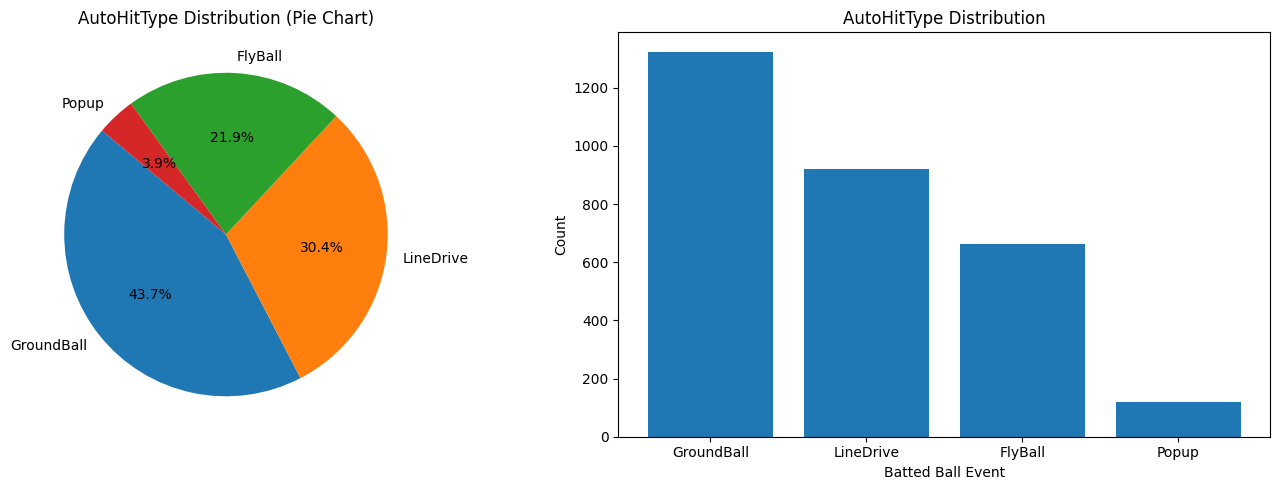

In [171]:

batted_ball_events = data['AutoHitType'].value_counts()
plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.pie(batted_ball_events, labels=batted_ball_events.index, autopct='%1.1f%%', startangle=140)
plt.title('AutoHitType Distribution (Pie Chart)')


plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.bar(batted_ball_events.index, batted_ball_events.values)
plt.title('AutoHitType Distribution')
plt.xlabel('Batted Ball Event')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


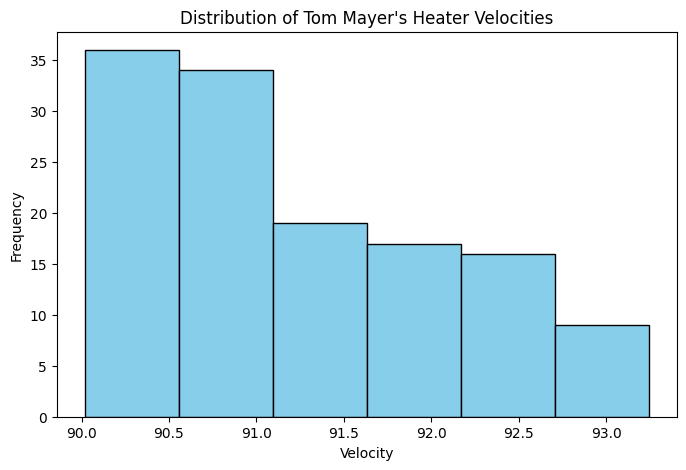

In [172]:
toms_pitches = data[data['Pitcher'] == 'Tom Mayer']
plt.figure(figsize=(8, 5))
plt.hist(toms_pitches[toms_pitches['RelSpeed'] > 90]['RelSpeed'], bins=6, color='skyblue', edgecolor='black')
plt.title('Distribution of Tom Mayer\'s Heater Velocities')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.show()


In [1]:
# show a table of the game pitchers and pitches thrown
# pd.crosstab(data.Pitcher, data.TaggedPitchType)

### Pitcher Plot Ideas

In [174]:
pd.set_option('display.max_columns', None) #see all the columns
data.head(10)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,Notes,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam
0,1.0,2024-04-02,18:07:28,1.0,1.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,0.0,0.0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,88.23068,-1.561024,-1.299457,2094.827310,212.044437,1:00,5.88337,1.29360,6.38183,-16.08910,19.13099,11.27241,3.10584,1.03735,80.63453,-4.659418,0.742300,0.427136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.23737,10.75426,-1.20491,50.0,5.76318,2.46703,-128.21920,-3.89863,-10.37501,26.71449,-14.28581,CAL_BEA,PAC_TIG,CalBerkeley,D1,PAC12,20240402-CalBerkeley-1,8a5e6e70-f156-11ee-a26f-4f6db6f4caea,88.24452,NaN,NaN,7.59616,NaN,NaN,NaN,NaN,NaN,NaN,1ba5b55c-8808-4da3-b059-437b0fe3c76d,2024-04-03,1:07:28,2024-04-02T18:07:27.9630000-07:00,2024-04-03T01:07:27.9630000Z,NaN,v3,471259.0,471406.0,02 April 2024 21:05-pacific@california,"Button, Nico",800888.0,Right,CAL_BEA
1,2.0,2024-04-02,18:07:41,1.0,2.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,1.0,0.0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,90.05343,-3.220109,-3.880684,2208.594455,206.006323,12:45,5.77512,1.29983,6.70209,-12.21166,21.31395,9.87394,1.80330,-1.43108,82.42442,-5.614585,-2.087530,0.416735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.24091,12.43158,-1.04499,50.0,5.55498,8.47341,-130.52875,-7.60045,-10.78668,27.00667,-10.68750,CAL_BEA,PAC_TIG,CalBerkeley,D1,PAC12,20240402-CalBerkeley-1,920f6cf0-f156-11ee-a26f-4f6db6f4caea,90.44709,NaN,NaN,7.62901,NaN,NaN,NaN,NaN,NaN,NaN,1ba5b55c-8808-4da3-b059-437b0fe3c76d,2024-04-03,1:07:41,2024-04-02T18:07:40.9510000-07:00,2024-04-03T01:07:40.9510000Z,NaN,v3,471259.0,471406.0,02 April 2024 21:05-pacific@california,"Button, Nico",800888.0,Right,CAL_BEA
2,3.0,2024-04-02,18:07:55,1.0,3.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,2.0,0.0,Fastball,Four-Seam,FoulBallNotFieldable,Undefined,Undefined,Undefined,0.0,0.0,NaN,88.81993,-2.867524,-2.524675,2110.200935,214.533242,1:15,5.72991,1.36663,6.69135,-16.03883,18.00950,11.71953,1.76614,0.03285,82.16342,-5.936708,-0.391075,0.419971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.88044,10.56851,-1.20293,50.0,5.53191,5.27437,-129.10100,-6.87331,-11.73701,24.17076,-14.14565,CAL_BEA,PAC_TIG,CalBerkeley,D1,PAC12,20240402-CalBerkeley-1,9a7c1a50-f156-11ee-a26f-4f6db6f4caea,89.75011,NaN,NaN,6.65650,NaN,NaN,NaN,NaN,NaN,NaN,1ba5b55c-8808-4da3-b059-437b0fe3c76d,2024-04-03,1:07:55,2024-04-02T18:07:55.0530000-07:00,2024-04-03T01:07:55.0530000Z,NaN,v3,471259.0,471406.0,02 April 2024 21:05-pacific@california,"Button, Nico",800888.0,Right,CAL_BEA
3,4.0,2024-04-02,18:08:14,1.0,4.0,Andres Galan,1.000071e+09,Right,CAL_BEA,"Metcho, Jack",1.000214e+09,Right,PAC_TIG,Undefined,1.0,Top,0.0,2.0,1.0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,89.46353,-3.649730,-2.484399,2023.773206,198.402586,12:30,5.72553,1.20123,6.72717,-13.662

In [175]:
data[data['Pitcher'] == "Tom Mayer"].head(3)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,Notes,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam
2042,1.0,2024-04-21,13:07:22,1.0,1.0,Tom Mayer,1.000050e+09,Right,CAL_BEA,"Bazzana, Travis",683953.0,Left,ORE_BEA,Undefined,1.0,Top,0.0,0.0,0.0,Sinker,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,92.01412,-3.841381,-3.202615,2215.847596,227.087788,1:30,5.87257,1.89314,5.74940,-20.13911,13.28733,13.10497,0.60710,0.00055,84.15009,-7.595077,-0.859109,0.416118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.69083,8.21079,-1.63546,50.0,5.54043,6.89507,-133.19570,-9.63588,-13.78080,29.29596,-17.46152,CAL_BEA,ORE_BEA,CalBerkeley,D1,PAC12,20240421-CalBerkeley-1,c3b89ba0-001a-11ef-821c-9f0dbe6b8cf4,90.58117,NaN,NaN,7.86404,NaN,NaN,NaN,NaN,NaN,NaN,2e3792d1-a527-4583-9cbd-8f7d39b8a35a,2024-04-21,20:07:22,2024-04-21T13:07:21.8860000-07:00,2024-04-21T20:07:21.8860000Z,NaN,v3,471259.0,471404.0,21 April 2024 16:05-oregonst@california,"Lomavita, Caleb",1.000235e+09,Right,CAL_BEA
2043,2.0,2024-04-21,13:07:37,1.0,2.0,Tom Mayer,1.000050e+09,Right,CAL_BEA,"Bazzana, Travis",683953.0,Left,ORE_BEA,Undefined,1.0,Top,0.0,1.0,0.0,Sinker,Sinker,StrikeCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,90.93833,-1.417631,-3.175825,2190.806826,252.805215,2:30,5.80266,2.03889,5.85278,-27.08498,7.28197,19.51430,2.22606,0.71117,82.10234,-6.467922,0.322135,0.421931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.06729,4.52142,-1.79247,50.0,5.67155,6.47238,-131.76356,-4.20440,-19.15688,32.02351,-24.34769,CAL_BEA,ORE_BEA,CalBerkeley,D1,PAC12,20240421-CalBerkeley-1,ccff2e40-001a-11ef-821c-9f0dbe6b8cf4,89.33309,NaN,NaN,8.83599,NaN,NaN,NaN,NaN,NaN,NaN,2e3792d1-a527-4583-9cbd-8f7d39b8a35a,2024-04-21,20:07:37,2024-04-21T13:07:37.3880000-07:00,2024-04-21T20:07:37.3880000Z,NaN,v3,471259.0,471404.0,21 April 2024 16:05-oregonst@california,"Lomavita, Caleb",1.000235e+09,Right,CAL_BEA
2044,3.0,2024-04-21,13:07:57,1.0,3.0,Tom Mayer,1.000050e+09,Right,CAL_BEA,"Bazzana, Travis",683953.0,Left,ORE_BEA,Undefined,1.0,Top,0.0,1.0,1.0,Fastball,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0.0,0.0,NaN,91.38273,-2.439848,-3.201901,2243.810391,216.905519,1:15,5.91065,2.08146,5.87436,-18.01249,15.61824,10.90335,2.13857,0.01305,83.43115,-5.840201,-1.249059,0.417388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.52575,9.02741,-1.82883,50.0,5.70261,6.94660,-132.46218,-6.21837,-11.57358,28.77245,-16.16371,CAL_BEA,ORE_BEA,CalBerkeley,D1,PAC12,20240421-CalBerkeley-1,d8885de0-001a-11ef-821c-9f0dbe6b8cf4,90.30559,NaN,NaN,7.95158,NaN,NaN,NaN,NaN,NaN,NaN,2e3792d1-a527-4583-9cbd-8f7d39b8a35a,2024-04-21,20:07:57,2024-04-21T13:07:56.7930000-07:00,2024-04-21T20:07:56.7930000Z,NaN,v3,471259.0,471404.0,21 April 2024 16:05-oregonst@california,"Lomavita, Caleb",1.000235e+09,Right,CAL_BEA


In [176]:
#pitch count list
data['Pitcher'].value_counts().head(10)

Pitcher
Luke Short           1313
Trey Newmann         1033
Christian Becerra     991
Andres Galan          720
Tyler Stasiowski      639
Tom Mayer             596
Connor Sullivan       500
Austin Turkington     470
Oliver Boone          411
Robert Aivazian       407
Name: count, dtype: int64

In [177]:
# pitch count by pitcher total
data[data['Pitcher'] == 'Tom Mayer']['TaggedPitchType'].value_counts().head(10)

TaggedPitchType
Sinker       159
Cutter       145
Slider       119
Splitter      75
Fastball      65
ChangeUp      24
Undefined      8
Curveball      1
Name: count, dtype: int64

#### Useful functions for model

In [178]:
# plot our function when we gotta build the model later
def show_history(history):
    plt.plot(history.history['loss'], color='black', label='train')
    plt.plot(history.history['val_loss'], color='red', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.show()
    print(f"Train Loss: {history.history['loss'][-1]}")
    print(f"Val Loss: {history.history['val_loss'][-1]}") #prints the last value of th loss function in that arr
